As a basic operational index, the short-term prediction of bike traffic flow plays a vital role in demand forecasting and rebalancing the resources of bike-sharing networks. A number of different methods have been proposed for forecasting bike traffic in recent years, but due to their high performance, deep learning (DL)-based models have dominated this area. With an hourly time step, this project predicts the number of trips between stations.
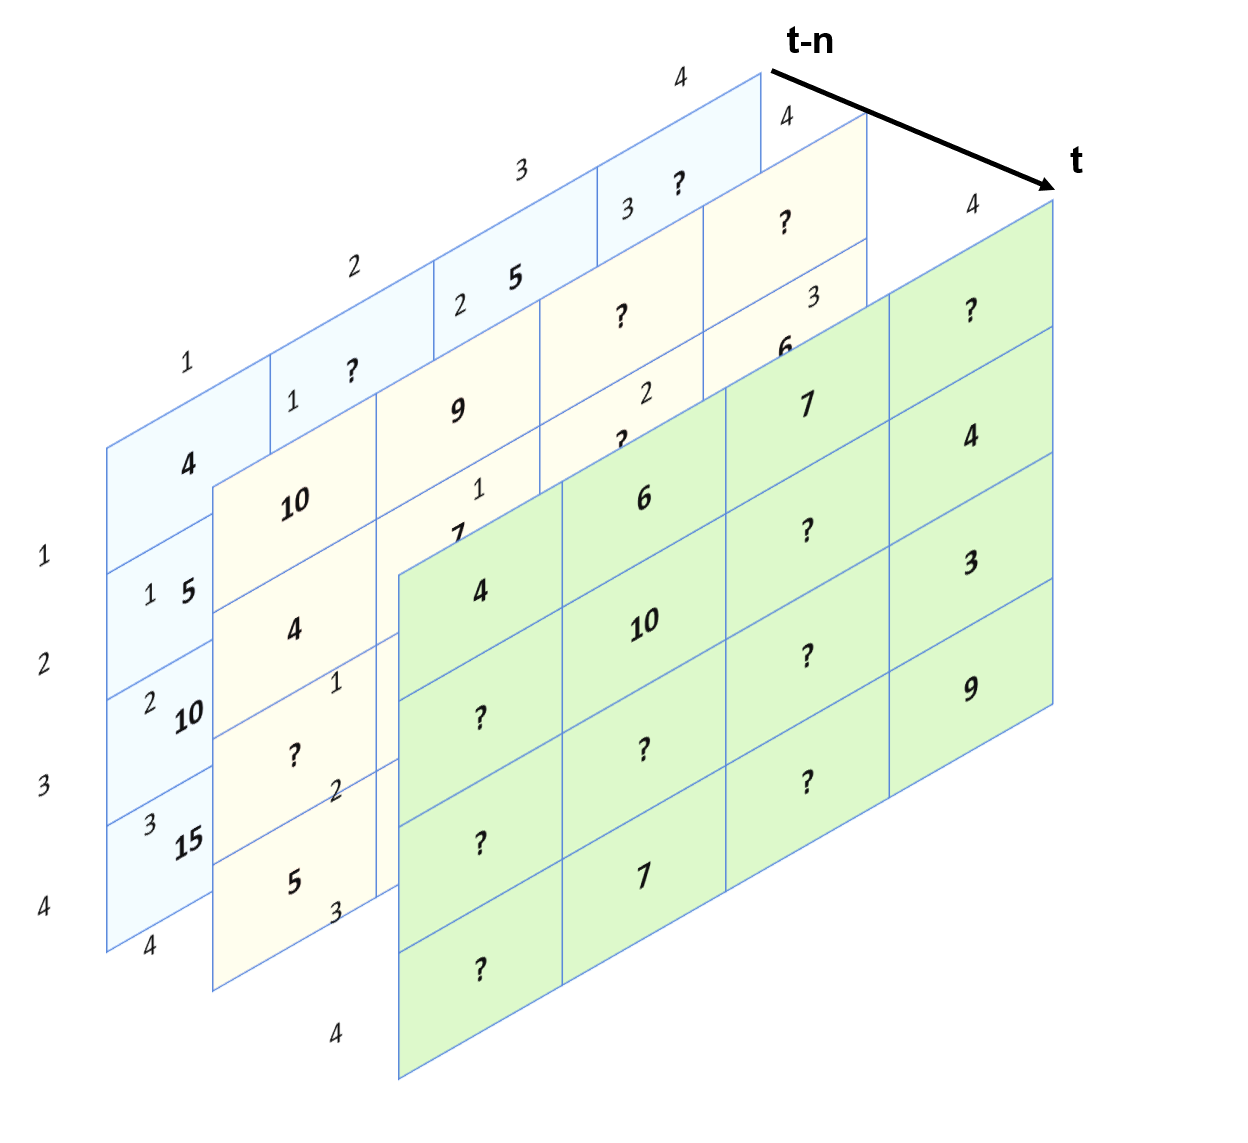

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta , date ,time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras import models, layers, utils
import keras

In [2]:
df=pd.DataFrame()
df_Q1=pd.read_csv(r'/content/drive/MyDrive/Divvy_Trips_2019_Q1.csv')
df_Q2=pd.read_csv(r'/content/drive/MyDrive/Divvy_Trips_2019_Q2.csv')
df_Q3=pd.read_csv(r'/content/drive/MyDrive/Divvy_Trips_2019_Q3.csv')
df_Q4=pd.read_csv(r'/content/drive/MyDrive/Divvy_Trips_2019_Q4.csv')
for i in [df_Q1 , df_Q2 , df_Q3 , df_Q4] :
  df=df.append(i)

<ipython-input-2-24a43d0bc8ed>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(i)
<ipython-input-2-24a43d0bc8ed>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(i)


In [3]:
df.tripduration=pd.to_numeric(df.tripduration.str.replace(',', ''), 'coerce' ) #remove comma in duration time for sum,...
'''convert str to datetime'''
df['start_time'] = df['start_time'].map(lambda x: datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S")) #convert str to datetime
df['date'] = df['start_time'].map(lambda x: datetime.strptime(str(x.date()),"%Y-%m-%d")) #create column date from start_time
df['time'] = df['start_time'].map(lambda x: x.hour) #cearte column time hour from start_time
# Remove stations that lack information
fill = df[ (df['from_station_id']==1) | (df['from_station_id']==360) | (df['from_station_id']==361) | (df['from_station_id']==363) | (df['from_station_id']==669) | (df['to_station_id']==1) | (df['to_station_id']==360) | (df['to_station_id']==361) | (df['to_station_id']==363) | (df['to_station_id']==669)].index
df.drop(index=fill , axis=0 , inplace=True)

In [4]:
#Creating a trajectory dataframe for each hour 
df1=df.groupby(['date','time','from_station_id', 'to_station_id']).agg({'trip_id':'count' , 'tripduration':np.mean}).reset_index()

df1.rename(columns={'from_station_id':'Start_station' , 'trip_id' : 'trip' , 'to_station_id':'End_station'} , inplace=True)

In [5]:
# import data weather and convert str to datetime 
weather=pd.read_csv('/content/drive/MyDrive/weather_new.csv')
weather['date_time'] = weather['date_time'].map(lambda x: datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S")) #convert column date_time to datetime
weather['date'] = weather['date_time'].map(lambda x: datetime.strptime(str(x.date()),"%Y-%m-%d")) #creating column date from column date_time
weather['time'] = weather['date_time'].map(lambda x: x.hour) #creating column time_hour from date_time


In [6]:
#Integrating weather data with trajectory data
df_weather=pd.merge(df1, weather[['date','time','humidity','precipMM','tempC','windspeedKmph']], on=['date','time'], how='left')
print(len(df_weather))

3213556


In [7]:
#import and merging two columns access pop and business
path_pop='/content/drive/MyDrive/pop.csv'
path_business='/content/drive/MyDrive/business.csv'
pop_access=pd.read_csv(path_pop) #import file access population
pop_access=pop_access.drop_duplicates(subset='station_id' , keep='first') ###drop duplicate station_id
business_acess=pd.read_csv(path_business) #import file access business
business_acess=business_acess.drop_duplicates(subset='station_id' , keep='first') ###drop duplicate station_id
origin_data=pd.merge(df_weather[['date','time','Start_station','humidity', 'precipMM', 'tempC', 'windspeedKmph']], pop_access[['station_id' , '_persons15']] , left_on='Start_station' , right_on='station_id' ,how='left')
origin_data=pd.merge(origin_data, business_acess[['station_id' , '_persons15']] , left_on='Start_station' , right_on='station_id' ,how='left')
origin_data.drop(['station_id_x', 'station_id_y'], axis=1, inplace=True)
origin_data.rename(columns={'_persons15_x':'Access_pop_origin' , '_persons15_y':'Access_business_origin' } , inplace=True)
destination_data=pd.merge(df_weather[['date','time','End_station','tripduration']], pop_access[['station_id' , '_persons15']] , left_on='End_station' , right_on='station_id' ,how='left')
destination_data=pd.merge(destination_data, business_acess[['station_id' , '_persons15']] , left_on='End_station' , right_on='station_id' ,how='left')
destination_data.drop(['station_id_x', 'station_id_y'], axis=1, inplace=True)
destination_data.rename(columns={'_persons15_x':'Access_pop_distination' , '_persons15_y':'Access_business_distination' } , inplace=True)

In [8]:
#split data to train and test 
target=df_weather['trip']
train_origin=origin_data[['time', 'Start_station', 'humidity', 'precipMM', 'tempC',
       'windspeedKmph', 'Access_pop_origin', 'Access_business_origin']].to_numpy()[:3000000]
test_origin=origin_data[['time', 'Start_station', 'humidity', 'precipMM', 'tempC',
       'windspeedKmph', 'Access_pop_origin', 'Access_business_origin']].to_numpy()[3000000:]
train_destination=destination_data[['time', 'End_station', 'tripduration', 'Access_pop_distination',
       'Access_business_distination']].to_numpy()[:3000000]
test_destination=destination_data[['time', 'End_station', 'tripduration', 'Access_pop_distination',
       'Access_business_distination']].to_numpy()[3000000:]
train_target=target[:3000000].to_numpy().reshape(-1,1)
test_target=target[3000000:].to_numpy().reshape(-1,1)

In [9]:
#Normalizing data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_origin=scaler.fit_transform(train_origin)
test_origin=scaler.fit_transform(test_origin)
train_destination=scaler.fit_transform(train_destination)
test_destination=scaler.fit_transform(test_destination)
train_target=scaler.fit_transform(train_target)
test_target=scaler.fit_transform(test_target)

In [10]:

# Implement MLP network for origin stations
Origin_in = layers.Input(name="Origin_in", shape=(train_origin.shape[1],))
Origin_1 = layers.Dense(64, activation='relu')(Origin_in)
Origin_2 = layers.Dense(32, activation='relu')(Origin_1)
Origin_3 = layers.Dense(16, activation='relu')(Origin_2)


# Implement MLP network for destination stations
destination_in = layers.Input(name="destination_in", shape=(train_destination.shape[1],))
destination_1 = layers.Dense(64, activation='relu')(destination_in)
destination_2 = layers.Dense(32, activation='relu')(destination_1)
destination_3 = layers.Dense(16, activation='relu')(destination_2)


# concating
xx = layers.Concatenate(axis=1)([Origin_3, destination_3])

# Predict traffic flow

y = layers.Dense(name="y", units=8, activation='relu')(xx)

y_out = layers.Dense(name="y_out", units=1, activation='linear')(y)

# Compile
model = models.Model(inputs=[Origin_in, destination_in], outputs=y_out)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

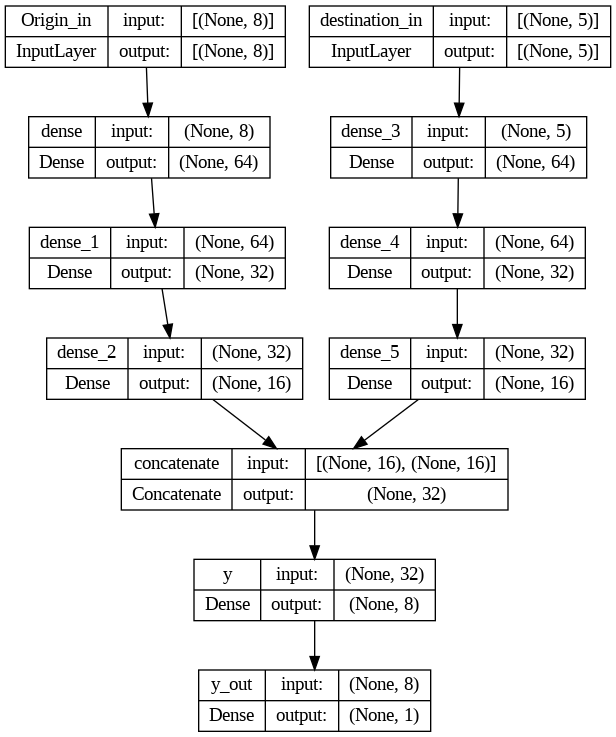

In [11]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
# Train
training = model.fit(x=[train_origin, train_destination], y=train_target, epochs=20, batch_size=128, shuffle=True, verbose=1, validation_split=0.3)

Epoch 1/20
16407/16407 [==============================] - 80s 5ms/step - loss: 0.9712 - mse: 0.9712 - val_loss: 0.8057 - val_mse: 0.8057
Epoch 2/20
16407/16407 [==============================] - 75s 5ms/step - loss: 0.9021 - mse: 0.9021 - val_loss: 0.7802 - val_mse: 0.7802
Epoch 3/20
16407/16407 [==============================] - 70s 4ms/step - loss: 0.8775 - mse: 0.8775 - val_loss: 0.7725 - val_mse: 0.7725
Epoch 4/20
16407/16407 [==============================] - 76s 5ms/step - loss: 0.8622 - mse: 0.8622 - val_loss: 0.7565 - val_mse: 0.7565
Epoch 5/20
16407/16407 [==============================] - 76s 5ms/step - loss: 0.8510 - mse: 0.8510 - val_loss: 0.7599 - val_mse: 0.7599
Epoch 6/20
16407/16407 [==============================] - 76s 5ms/step - loss: 0.8407 - mse: 0.8407 - val_loss: 0.7466 - val_mse: 0.7466
Epoch 7/20
16407/16407 [==============================] - 70s 4ms/step - loss: 0.8318 - mse: 0.8318 - val_loss: 0.7398 - val_mse: 0.7398
Epoch 8/20
16407/16407 [=================

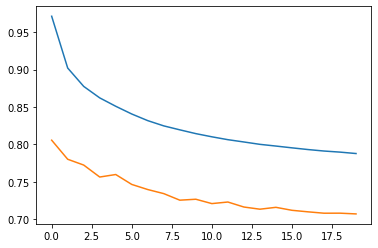

In [13]:
#Comparing loss train data with validation data
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])

In [14]:
# Evaluation model
yhat = model.predict(x=[test_origin, test_destination], verbose=1)
r_2=r2_score(test_target,yhat)
MSE=mean_squared_error(test_target,yhat)
RMSE=mean_squared_error(test_target,yhat, squared=False)
print('R^2: '+ str(r_2) + '\n' + 'MSE: '+ str(MSE) + '\n' + 'RMSE: '+ str(RMSE))

6674/6674 [==============================] - 12s 2ms/step
R^2: 0.10150222934939113
MSE: 0.8984977706506088
RMSE: 0.9478912230053661
